In [6]:
import arviz as az
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import extract_intercept_gamma
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
bids_folder = '/data/ds-risk'

In [8]:
sessions = ['3t2', '7t2']

df = []
behavior = []

for session in sessions:
    data = get_data('probit_simple', session, bids_folder)
    behavior.append(data)
    model = build_model('probit_simple', data, session, bids_folder)
    idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-probit_simple_ses-{session}_trace.netcdf')
    intercept, gamma = extract_intercept_gamma(idata, model, data)

    intercept = intercept.groupby('subject').mean().mean(1).rename('intercept')
    gamma = gamma.groupby('subject').mean().mean(1).rename('gamma')

    rnp = np.clip(np.exp(intercept/gamma),0, 1).rename('rnp')
    df.append(gamma.to_frame().join(rnp))

df = pd.concat(df, keys=sessions, names=['session'])
behavior = pd.concat(behavior, keys=sessions, names=['session'])

100%|██████████| 30/30 [00:00<00:00, 31.15it/s]


['subject', 'x', 'n_safe', 'risky_first']


100%|██████████| 30/30 [00:00<00:00, 31.23it/s]


['subject', 'x', 'n_safe', 'risky_first']


In [9]:
sns.set_context('talk')

Text(0.5, 50.999999999999986, 'precision')

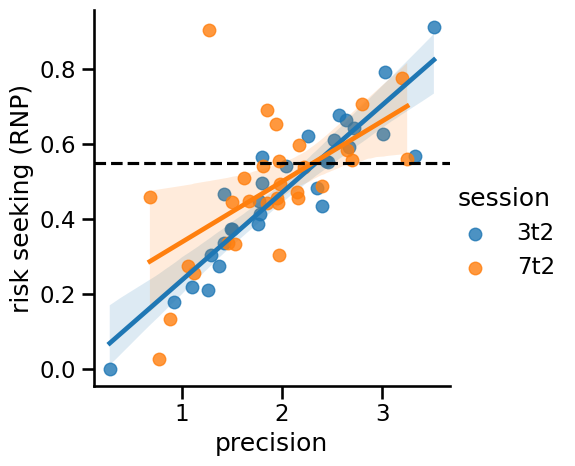

In [10]:
fac = sns.lmplot(df.reset_index(), x='gamma', y='rnp', hue='session')
plt.axhline(0.55, c='k', ls='--')
# fac.set(xlim=(0,1))
# plt.ylim(0, 1)

plt.ylabel('risk seeking (RNP)')
plt.xlabel('precision')

In [13]:
df

gamma       rnp
session subject                    
3t2     02       2.517197  0.609926
        03       0.277188  0.000858
        04       1.767658  0.447714
        05       1.288845  0.303384
        06       1.366840  0.275716
        07       0.916875  0.178675
        08       1.489536  0.374114
        09       2.459175  0.552457
        10       2.437462  0.555994
        11       1.421987  0.336965
        12       2.718802  0.642034
        13       1.780012  0.414903
        14       3.028488  0.791005
        15       2.397812  0.435909
        16       2.041810  0.542626
        17       3.517736  0.911679
        18       2.567485  0.677936
        19       1.416829  0.466105
        20       1.494591  0.374898
        21       1.098517  0.218894
        22       2.344557  0.483359
        23       2.263156  0.622287
        25       2.670066  0.591334
        26       3.008748  0.627504
        27       2.641175  0.663705
        28       3.331646  0.568798
        29       1.800926  0.495636
        30       1.798212  0.566671
        31       1.756808  0.387552
        32       1.259119  0.211478
7t2     02       2.695801  0.556947
        03       0.678458  0.458567
        04       1.810971  0.542769
        05       1.118733  0.255288
        06       1.945699  0.457550
        07       1.966088  0.303929
        08       1.672454  0.447987
        09       2.652270  0.583723
        10       2.162736  0.455887
        11       1.533917  0.332615
        12       2.218540  0.537878
        13       1.615757  0.509935
        14       1.971539  0.554790
        15       2.150825  0.472244
        16       1.456193  0.335693
        17       3.194491  0.776986
        18       1.936355  0.652480
        19       1.852714  0.691896
        20       1.063427  0.274498
        21       0.880644  0.133196
        22       1.954602  0.443263
        23       2.796962  0.706530
        25       1.980991  0.492901
        26       2.395724  0.487576
        27       2.170477  0.596292
        28       3.250406  0.560425
        29       1.265688  0.903554
        30       1.502520  0.445422
        31       1.846081  0.443332
        32       0.773611  0.026833

In [12]:
df.to_csv('/data/ds-risk/derivatives/cogmodels/gamma_rnp_simple.tsv', sep='\t')

In [15]:
import os.path as op

In [26]:
from risk_experiment.utils.data import get_all_behavior

In [28]:
df = get_all_behavior(sessions=session, bids_folder=bids_folder, drop_outliers=False)

100%|██████████| 30/30 [00:01<00:00, 26.03it/s]


In [38]:
rnp = pd.read_csv(op.join(bids_folder, 'derivatives', 'cogmodels', 'gamma_rnp_simple.tsv'), sep='\t', index_col=[0,1], dtype={'subject':str})[['rnp']]
rnp['risk preference'] = (rnp['rnp'] > 0.55).map({True:'risk seeking', False:'risk averse'})

In [41]:
df.join(rnp)

rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob1  \
subject session run trial_nr                                               
02      7t2     1   1                high uncertainty  19.0  10.0   0.55   
                    2                high uncertainty  98.0  28.0   0.55   
                    3                high uncertainty  52.0  20.0   0.55   
                    4                 low uncertainty  66.0  28.0   0.55   
                    5                 low uncertainty  17.0  10.0   0.55   
...                                               ...   ...   ...    ...   
32      7t2     8   188               low uncertainty  26.0  10.0   0.55   
                    189              high uncertainty  15.0   7.0   0.55   
                    190               low uncertainty  34.0  28.0   0.55   
                    191               low uncertainty  34.0  28.0   0.55   
                    192              high uncertainty  28.0   7.0   0.55   

                              prob2    p1   p2  ...  chose_risky        Order  \
subject session run trial_nr                    ...                             
02      7t2     1   1           1.0  0.55  1.0  ...        False  Risky first   
                    2           1.0  0.55  1.0  ...         True  Risky first   
                    3           1.0  0.55  1.0  ...         True  Risky first   
                    4           1.0  0.55  1.0  ...         True  Risky first   
                    5           1.0  0.55  1.0  ...         True  Risky first   
...                             ...   ...  ...  ...          ...          ...   
32      7t2     8   188         1.0  0.55  1.0  ...        False  Risky first   
                    189         1.0  0.55  1.0  ...        False  Risky first   
                    190         1.0  0.55  1.0  ...        False  Risky first   
                    191         1.0  0.55  1.0  ...        False  Risky first   
                    192         1.0  0.55  1.0  ...        False  Risky first   

                              n_risky  n_safe      frac  log(risky/safe)  \
subject session run trial_nr                                               
02      7t2     1   1            19.0    10.0  1.900000         0.641854   
                    2            98.0    28.0  3.500000         1.252763   
                    3            52.0    20.0  2.600000         0.955511   
                    4            66.0    28.0  2.357143         0.857450   
                    5            17.0    10.0  1.700000         0.530628   
...                               ...     ...       ...              ...   
32      7t2     8   188          26.0    10.0  2.600000         0.955511   
                    189          15.0     7.0  2.142857         0.762140   
                    190          34.0    28.0  1.214286         0.194156   
                    191          34.0    28.0  1.214286         0.194156   
                    192          28.0     7.0  4.000000         1.386294   

                             bin(risky/safe)   log(n1)       rnp  \
subject session run trial